<a href="https://colab.research.google.com/github/velasoka-repo/EVA4/blob/master/Session-5/EVA4_S5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Github Link](https://github.com/velasoka-repo/EVA4/blob/master/Session-5/EVA4_S5_3.ipynb)

#Target:
1. Basic Transforms (ToTensor, Normalize)
2. Basic Data Loader (Train & Test)
3. Improved Basic CNN Model
4. Basic Training  & Test Loop
5. **Add GAP Layer** (It reduces Parameter)
6. **Improve Test Accuracy** (by increase model capacity)

#Results: (GAP Layer without Dropout)
1. Parameters: `9,866`
2. Best Training Accuracy: `99.71%` 
3. Best Test Accuracy: `99.43%`
4. Epochs: 15

# Analysis: (GAP Layer without Dropout)
1. Increasing model capacity is increasing Accuracy. Parameters `9,866`
2. Train Accuracy is increasing for each epoch
3. Test Accuracy closely stable (Accuracy is slightly going UP & DOWN 0.2%)
4. Seeing bit of Overfitting(Train: `99.71%`, Test: `99.43%`)

- - -

#Results: (GAP Layer, 1 Dropout)
1. Parameters: `9,866`
2. Best Training Accuracy: `99.45%` 
3. Best Test Accuracy: `99.39%`
4. Epochs: 15

# Analysis: (GAP Layer, 1 Dropout)
1. Increasing model capacity is increasing Accuracy. Parameters `9,866`
2. Train Accuracy is increasing for each epoch
3. Test Accuracy less stable (Accuracy is slightly going UP & DOWN 0.2%)
4. No Overfitting(Train: `99.45%`, Test: `99.39%`)



# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

Applying following three transformation

1.   Compose - group multiple transform into sequential transform
2.   ToTensor - Convert numpy | PILImage to tensor and convert range between 0-1 
`(i.e) array/255`
3. Normalize - input data(train & test) is normalized besed on `mean` & `std` 
`(i.e) (i'th value - mean)/std => final i'th range becomes (-1, 1)`

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 6

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Training and Testing

In [0]:
def train(model, device, train_loader, optimizer, epoch, train_repo):
  train_losses, train_acc = train_repo
  model.train()
  pbar = tqdm(iterable=train_loader, total=len(train_loader), position=0)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_repo):
    test_losses, test_acc = test_repo
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Draw Accuracy Graph

In [0]:
def draw_accuracy(train_repo, test_repo):
  train_losses, train_acc = train_repo
  test_losses, test_acc = test_repo
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

# Training Model (1)
* GAP layer 
* Removed Dropout
* Increasing Model capacity

In [0]:
class GAP(nn.Module):
    def __init__(self, fm_size):
        super(GAP, self).__init__()
        self.fm_size = fm_size
        self.num_classes = 10
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 24

        # self.fm_size *=2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.2), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.2)),
        ) # output_size = 22
        
        self.fm_size = int(self.fm_size*1.2)
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size/1.2), kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size/1.2)),
        ) # output_size = 11

        self.fm_size = int(self.fm_size/1.2)
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 9

        # self.fm_size *=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.5), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.5)),
        ) # output_size = 7

        self.fm_size = int(self.fm_size*1.5)
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.num_classes, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.num_classes),
        ) # output_size = 7

        self.avg = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_classes, out_channels=self.num_classes, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)

        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.avg(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model Params

In [76]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Available device: {device}")
model = GAP(14).to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
            Conv2d-4           [-1, 14, 24, 24]           1,764
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
            Conv2d-7           [-1, 16, 22, 22]           2,016
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        Dropout2d-10           [-1, 16, 22, 22]               0
        MaxPool2d-11           [-1, 16, 11, 11]               0
           Conv2d-12           [-1, 13, 11, 11]             208
             ReLU-13           [-1, 13, 11, 11]               0
      BatchNorm2

### Train and test our model

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.07436477392911911 Batch_id=468 Accuracy=89.77: 100%|██████████| 469/469 [00:12<00:00, 36.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0772, Accuracy: 9802/10000 (98.02%)

EPOCH: 2


Loss=0.061812255531549454 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:12<00:00, 38.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9870/10000 (98.70%)

EPOCH: 3


Loss=0.05869942530989647 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 38.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9887/10000 (98.87%)

EPOCH: 4


Loss=0.0812440738081932 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:12<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9920/10000 (99.20%)

EPOCH: 5


Loss=0.03130747005343437 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 39.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9936/10000 (99.36%)

EPOCH: 6


Loss=0.046569857746362686 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 40.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9906/10000 (99.06%)

EPOCH: 7


Loss=0.010303216986358166 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:11<00:00, 39.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.010677416808903217 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:12<00:00, 38.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.027691347524523735 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:11<00:00, 39.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.015447343699634075 Batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:11<00:00, 40.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.023945122957229614 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:11<00:00, 41.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.005805010441690683 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:12<00:00, 38.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.06751186400651932 Batch_id=468 Accuracy=99.59: 100%|██████████| 469/469 [00:12<00:00, 38.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.10432402044534683 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:12<00:00, 38.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.021776536479592323 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:11<00:00, 39.50it/s]



Test set: Average loss: 0.0219, Accuracy: 9943/10000 (99.43%)

---------------------------------------------------------------------------


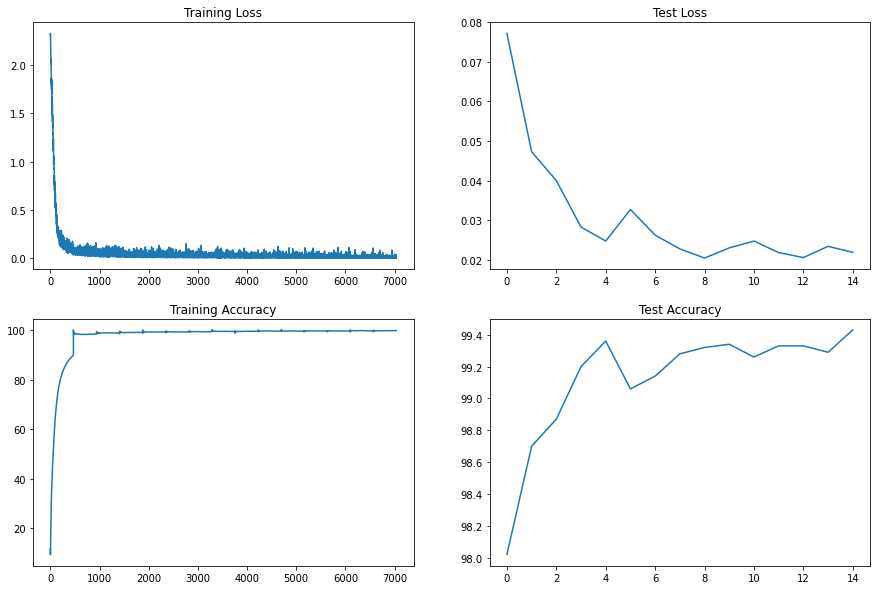

In [0]:
model =  GAP(14).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
test_repo = ([], [])
train_repo = ([], [])
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_repo)
    test(model, device, test_loader, test_repo)

print("-"*75)
draw_accuracy(train_repo, test_repo)

# Training Model (2)
* GAP layer 
* Seen a bit of Overfitting, so removing dropout, adding 1 Dropout with 0.1 value
* Increasing Model capacity

In [0]:
class GAP(nn.Module):
    def __init__(self, fm_size, dropout_value=0.25):
        super(GAP, self).__init__()
        self.fm_size = fm_size
        self.num_classes = 10
        self.dropout_value = dropout_value
        self.dropout = nn.Dropout2d(self.dropout_value)
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 24

        # self.fm_size *=2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.2), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.2)),
        ) # output_size = 22
        
        self.fm_size = int(self.fm_size*1.2)
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size/1.2), kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size/1.2)),
        ) # output_size = 11

        self.fm_size = int(self.fm_size/1.2)
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.fm_size, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.fm_size),
        ) # output_size = 9

        # self.fm_size *=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=int(self.fm_size*1.5), kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=int(self.fm_size*1.5)),
        ) # output_size = 7

        self.fm_size = int(self.fm_size*1.5)
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=self.fm_size, out_channels=self.num_classes, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.num_classes),
        ) # output_size = 7

        self.avg = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=self.num_classes, out_channels=self.num_classes, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        # x = self.dropout(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.avg(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

### Model Params

In [74]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Available device: {device}")
model = GAP(14, 0.1).to(device)
summary(model, input_size=(1, 28, 28))

Available device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
            Conv2d-4           [-1, 14, 24, 24]           1,764
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
            Conv2d-7           [-1, 16, 22, 22]           2,016
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        Dropout2d-10           [-1, 16, 22, 22]               0
        MaxPool2d-11           [-1, 16, 11, 11]               0
           Conv2d-12           [-1, 13, 11, 11]             208
             ReLU-13           [-1, 13, 11, 11]               0
      BatchNorm2

### Train and test our model

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.07545789331197739 Batch_id=468 Accuracy=89.22: 100%|██████████| 469/469 [00:12<00:00, 36.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0732, Accuracy: 9799/10000 (97.99%)

EPOCH: 2


Loss=0.04040460288524628 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:12<00:00, 36.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9862/10000 (98.62%)

EPOCH: 3


Loss=0.04763173684477806 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:12<00:00, 37.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.04161800444126129 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:12<00:00, 37.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.09312736988067627 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 38.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.050370100885629654 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:12<00:00, 37.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Loss=0.02090887911617756 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:12<00:00, 38.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9928/10000 (99.28%)

EPOCH: 8


Loss=0.08905569463968277 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 37.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.020725974813103676 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 37.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.015329495072364807 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 37.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.0326109416782856 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:11<00:00, 39.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.03733624517917633 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH: 13


Loss=0.01015422772616148 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:11<00:00, 39.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.01112790871411562 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 37.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Loss=0.005176424980163574 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]



Test set: Average loss: 0.0222, Accuracy: 9938/10000 (99.38%)

---------------------------------------------------------------------------


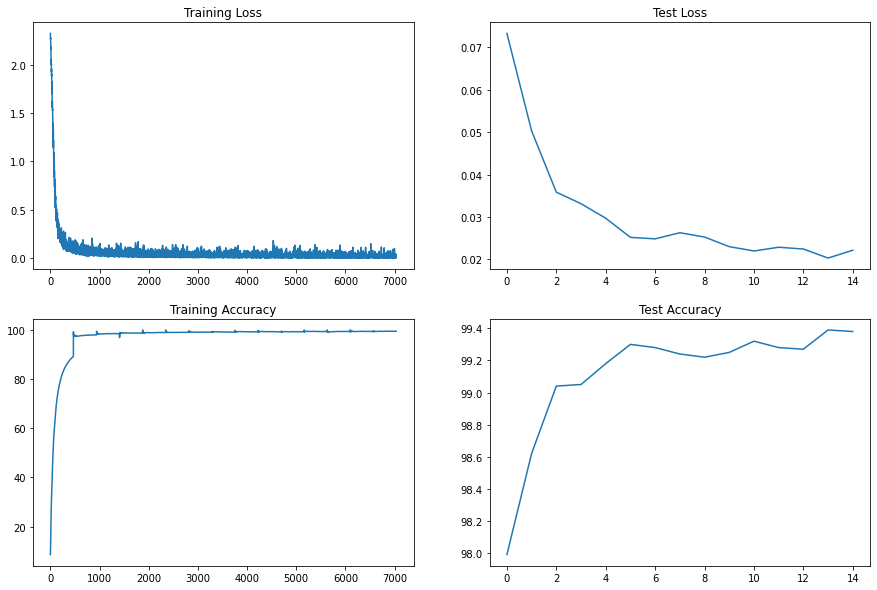

In [75]:
model =  GAP(14, 0.1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
test_repo = ([], [])
train_repo = ([], [])
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, train_repo)
    test(model, device, test_loader, test_repo)

print("-"*75)
draw_accuracy(train_repo, test_repo)